<a href="https://colab.research.google.com/github/WoradeeKongthong/raining_tomorrow_classification/blob/master/09_Raining_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


# Dataset

In [0]:
df = pd.read_csv('https://raw.githubusercontent.com/WoradeeKongthong/raining_tomorrow_classification/master/weatherAUS.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 24 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           142193 non-null  object 
 1   Location       142193 non-null  object 
 2   MinTemp        141556 non-null  float64
 3   MaxTemp        141871 non-null  float64
 4   Rainfall       140787 non-null  float64
 5   Evaporation    81350 non-null   float64
 6   Sunshine       74377 non-null   float64
 7   WindGustDir    132863 non-null  object 
 8   WindGustSpeed  132923 non-null  float64
 9   WindDir9am     132180 non-null  object 
 10  WindDir3pm     138415 non-null  object 
 11  WindSpeed9am   140845 non-null  float64
 12  WindSpeed3pm   139563 non-null  float64
 13  Humidity9am    140419 non-null  float64
 14  Humidity3pm    138583 non-null  float64
 15  Pressure9am    128179 non-null  float64
 16  Pressure3pm    128212 non-null  float64
 17  Cloud9am       88536 non-null

In [0]:
# drop RISK_MM
df.drop(['RISK_MM'], axis=1, inplace=True)

# Handle the date column
df['Date'] = pd.to_datetime(df['Date'])
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
#drop the unused 'Date' column
df.drop(['Date'], axis=1, inplace=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 142193 entries, 0 to 142192
Data columns (total 25 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Location       142193 non-null  object 
 1   MinTemp        141556 non-null  float64
 2   MaxTemp        141871 non-null  float64
 3   Rainfall       140787 non-null  float64
 4   Evaporation    81350 non-null   float64
 5   Sunshine       74377 non-null   float64
 6   WindGustDir    132863 non-null  object 
 7   WindGustSpeed  132923 non-null  float64
 8   WindDir9am     132180 non-null  object 
 9   WindDir3pm     138415 non-null  object 
 10  WindSpeed9am   140845 non-null  float64
 11  WindSpeed3pm   139563 non-null  float64
 12  Humidity9am    140419 non-null  float64
 13  Humidity3pm    138583 non-null  float64
 14  Pressure9am    128179 non-null  float64
 15  Pressure3pm    128212 non-null  float64
 16  Cloud9am       88536 non-null   float64
 17  Cloud3pm       85099 non-null

# X & y

In [0]:
X = df.drop(['RainTomorrow'], axis=1)
y = df['RainTomorrow'].replace(['Yes','No'],[1,0])

# Training and Test sets

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# **Handle the Outliers**
Training Set
- cap the outliers in X_train

Test Set
- cap the outliers in X_test using the upper_cap and lower_cap of X_train

## **Cap the outlier in X_train**

In [0]:
Q1 = X_train.quantile(0.25)
Q3 = X_train.quantile(0.75)
IQR = Q3 - Q1

lower_cap = Q1 - 1.5*IQR
upper_cap = Q3 + 1.5*IQR

features = lower_cap.index.values

for feature in features :
  X_train.loc[:,feature] = np.where(X_train.loc[:,feature]<lower_cap[feature],lower_cap[feature], X_train.loc[:,feature])
  X_train.loc[:,feature] = np.where(X_train.loc[:,feature]>upper_cap[feature],upper_cap[feature], X_train.loc[:,feature])

## **Cap the outlier in X_test**

In [0]:
for feature in features :
  X_test.loc[:,feature] = np.where(X_test.loc[:,feature]<lower_cap[feature],lower_cap[feature], X_test.loc[:,feature])
  X_test.loc[:,feature] = np.where(X_test.loc[:,feature]>upper_cap[feature],upper_cap[feature], X_test.loc[:,feature])

# ANN with pipeline

## **Create Preprocessor : ColumnTransformer of numerical and categorical features**

In [0]:
numerical_features = [x for x in X.columns if df[x].dtype != 'object']

numeric_transformer = Pipeline(steps=[
          ('imputer', SimpleImputer(strategy='median')),
          ('scaler', MinMaxScaler())
])

categorical_features = [x for x in X.columns if df[x].dtype == 'object']

categorical_transformer = Pipeline(steps=[
          ('imputer', SimpleImputer(strategy='most_frequent')),
          ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
          ('num', numeric_transformer, numerical_features),
          ('cat', categorical_transformer, categorical_features)
    ]
)

## **Create ANN and find the best one**

In [0]:
X_train_copied = preprocessor.fit_transform(X_train)

In [12]:
X_train_copied.shape

(113754, 118)

### Starter ANN

In [0]:
# ANN architecture
model = Sequential()
model.add(Dense(units=118, kernel_initializer='uniform', activation='relu', input_dim=118))
model.add(Dense(units=60, kernel_initializer='uniform', activation='relu'))
model.add(Dense(units=15, kernel_initializer='uniform', activation='relu'))
model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [0]:
# function for showing the evaluation of the model
def evaluate_model(history):
  # print final metrics for training and validation sets
  print('Training accuracy : ', history.history['accuracy'][-1])
  print('Validation accuracy : ', history.history['val_accuracy'][-1])

  fig = plt.figure(figsize=(12,4))

  # plot the model accuracy
  fig.add_subplot(121)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['training set', 'validation set'], loc='upper left')

  # plot the model loss
  fig.add_subplot(122)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['training set', 'validation set'], loc='upper left')
  
  fig.tight_layout()
  plt.show()

Training the ANN classifier along with doing the cross validation.

Training accuracy :  0.88720155
Validation accuracy :  0.8491934537887573


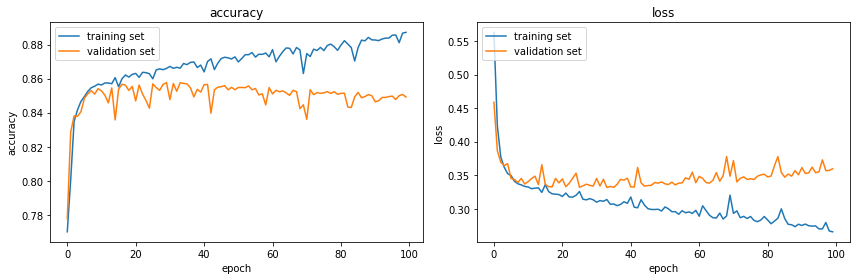

In [33]:
# Training the ANN
history = model.fit(X_train_copied, y_train, validation_split=0.2, batch_size=1000, epochs=100,verbose=0)
evaluate_model(history)

Note :  
Looks like we have overfitting problem.

### Try adding Dropout Regularization.

In [0]:
# ANN architecture
model = Sequential()
model.add(Dense(units=118, kernel_initializer='uniform', activation='relu', input_dim=118))
model.add(Dropout(0.4))
model.add(Dense(units=60, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=15, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Training accuracy :  0.8704988
Validation accuracy :  0.8545119166374207


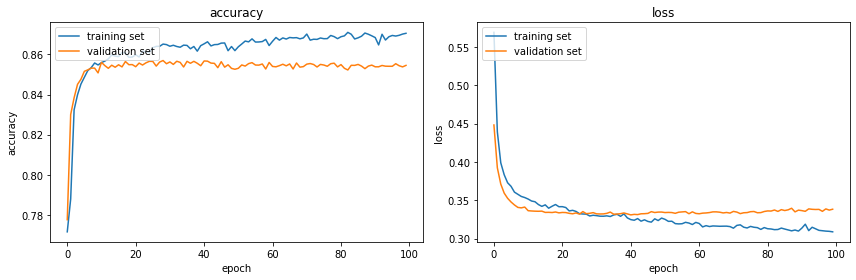

In [35]:
# Training the ANN
history = model.fit(X_train_copied, y_train, validation_split=0.2, batch_size=1000, epochs=100,verbose=0)
evaluate_model(history)

Note :  
The ANN is low variance.  
I'm not sure if this loss level define high bias.  
Try add more layers.

In [0]:
# ANN architecture
model = Sequential()
model.add(Dense(units=118, kernel_initializer='uniform', activation='relu', input_dim=118))
model.add(Dropout(0.4))
model.add(Dense(units=60, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=60, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=15, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

Training accuracy :  0.8696966
Validation accuracy :  0.8548195958137512


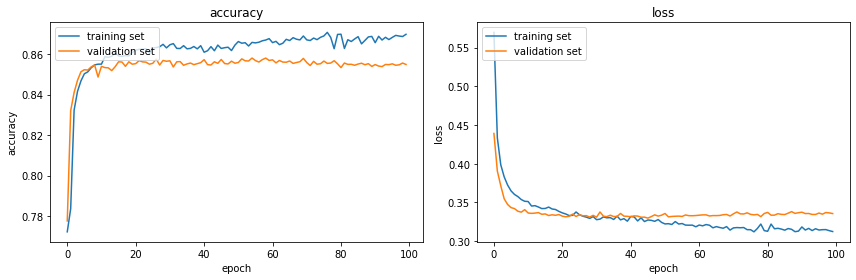

In [37]:
# Training the ANN
history = model.fit(X_train_copied, y_train, validation_split=0.2, batch_size=1000, epochs=100,verbose=0)
evaluate_model(history)

Note :  
- The accuracy is not increased.
- The loss is not decreased.
- The former model is better in timimg.

## wrap the final ANN with KerasClassifier

In [0]:
# function for creating ANN model
def create_model():
  # ANN architecture
  model = Sequential()
  model.add(Dense(units=118, kernel_initializer='uniform', activation='relu', input_dim=118))
  model.add(Dropout(0.4))
  model.add(Dense(units=60, kernel_initializer='uniform', activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(units=15, kernel_initializer='uniform', activation='relu'))
  model.add(Dropout(0.4))
  model.add(Dense(units=1, kernel_initializer='uniform', activation='sigmoid'))
  # compile the model
  model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
  return model

model = KerasClassifier(build_fn=create_model, batch_size=1000, epochs=100,verbose=0)

## **Create Pipeline**

In [0]:
clf = Pipeline(steps=[
      ('preprocessor', preprocessor),
      ('model', model)
])

# **Model Evaluation**

## **Cross Validation**

In [21]:
accuracy = cross_val_score(clf,X_train,y_train,cv=10)
print('accuracy : ', accuracy)
print('mean : ', accuracy.mean())
print('std : ', accuracy.std())

accuracy :  [0.85671592 0.85574895 0.85944092 0.85706753 0.85723078 0.86312085
 0.85837364 0.85696703 0.85854948 0.85863733]
mean :  0.8581852436065673
std :  0.0019505971102909627


Note :  
The model is low bias, and very low variance.

## **Training and Test evaluation**

In [41]:
clf.fit(X_train,y_train)
y_pred = clf.predict(X_test)

print('\n\nTraining and Test Sets result')
print('\naccuracy score : ', accuracy_score(y_test,y_pred))
print('\nconfusion matrix : \n', confusion_matrix(y_test, y_pred))
print('\nclassification report : \n', classification_report(y_test,y_pred))

print('Training set score : ',clf.score(X_train,y_train))
print('Test set score : ',clf.score(X_test,y_test))



Training and Test Sets result

accuracy score :  0.8582228629698653

confusion matrix : 
 [[20996  1017]
 [ 3015  3411]]

classification report : 
               precision    recall  f1-score   support

           0       0.87      0.95      0.91     22013
           1       0.77      0.53      0.63      6426

    accuracy                           0.86     28439
   macro avg       0.82      0.74      0.77     28439
weighted avg       0.85      0.86      0.85     28439

Training set score :  0.884680986404419
Test set score :  0.8582228422164917
